In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import xgboost

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

### Reading our data

In [4]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


### Dropping dome rows

#### thal column is very unbalanced that's why we are dropping thal=0 instances which are just 2

In [6]:
df['thal'].value_counts()

thal
2    166
3    117
1     18
0      2
Name: count, dtype: int64

In [7]:
rowstodrop = df[df['thal']==0]
df.drop(index=rowstodrop.index,axis=0,inplace=True)

In [8]:
df['thal'].value_counts()

thal
2    166
3    117
1     18
Name: count, dtype: int64

### Creating Features and Target dataframes

In [9]:
X = df.drop('target',axis=1)
y = df['target']

X.shape, y.shape

((301, 13), (301,))

### USING CORRELATION MATRIX

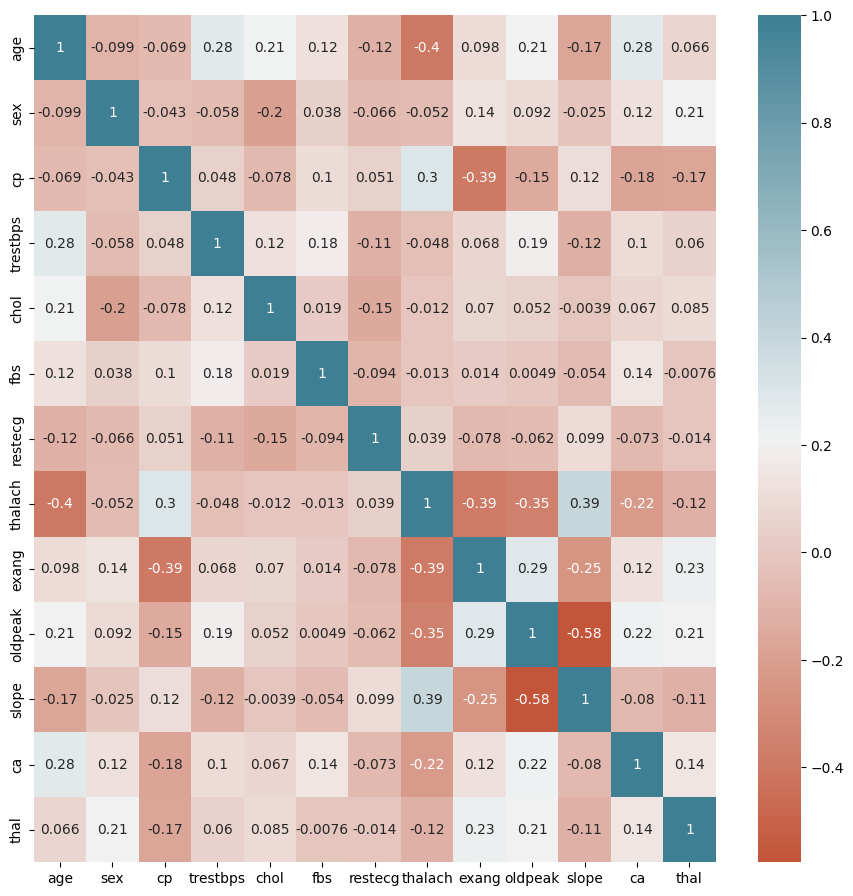

In [10]:
corr_mat = X.corr()
plt.figure(figsize=(11, 11))
g = sns.heatmap(corr_mat, annot=True, cmap=sns.diverging_palette(20, 220, n=200))

### Select K best using Chi^2 test

#### USING FEATURE IMPORTANCE - This technique gives you a score for each feature of your data,the higher the score more relevant it is

In [11]:
ordered_rank_features = SelectKBest(score_func=chi2, k=13)
ordered_feature = ordered_rank_features.fit(X, y)

feat_imp = pd.DataFrame(ordered_feature.scores_,index=X.columns, columns=["Score"])
feat_imp.sort_values(by='Score',inplace=True,ascending=False)
feat_imp

,Score
thalach,194.513757
oldpeak,72.012196
ca,66.592015
cp,61.185148
exang,38.015155
chol,24.748493
age,23.540050
trestbps,14.946629
slope,9.575327
sex,7.245619


### USING INFORMATION GAIN

In [12]:
mutual_info = mutual_info_classif(X, y)
mutual_info_df = pd.DataFrame(mutual_info*100, index=X.columns,columns=['Score'])
mutual_info_df.sort_values(by='Score',inplace=True,ascending=False)
mutual_info_df

,Score
cp,19.565249
thal,16.199016
ca,14.568035
chol,10.188835
exang,8.085866
oldpeak,7.301678
thalach,6.798444
slope,6.405540
sex,2.935587
age,0.000000


### FINAL SELECTION

In [13]:
final_selected_features = ['ca', 'cp', 'exang', 'thal', 'oldpeak', 'thalach','age']
X = X[final_selected_features]
X.shape

(301, 7)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

### Training RANDOM FOREST

In [15]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# random forest classifier accuracy:
y_preds = rfc.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 86.96%


[[15  1]
 [ 5 25]]


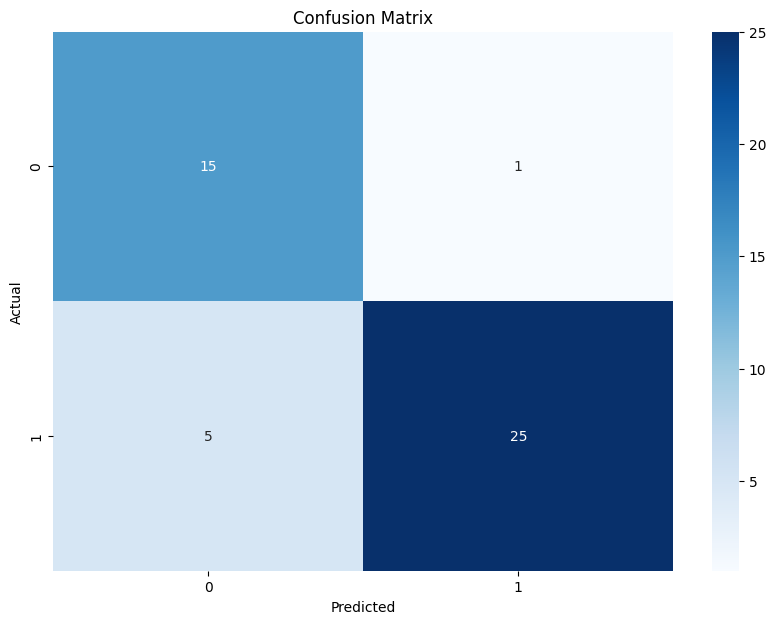

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_preds)
print(conf_mat)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Training XGBOOST

In [17]:
clf = xgboost.XGBClassifier()
clf.fit(X_train, y_train)

# xgboost classifier accuracy:
y_preds = clf.predict(X_test)
print("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_preds)*100))

Accuracy : 78.26%


In [18]:
# saving trained model
filename = '../models/heart_disease.pickle.dat'
pickle.dump(rfc, open(filename, 'wb'))